# Helmholtz problem

This example notebook shows how to setup

In [1]:
from jax import numpy as jnp
import numpy as np
from functools import partial
from jax import random
import jax
from matplotlib import pyplot as plt

key = random.PRNGKey(42)

# 3D Helmholtz equation solver

Running 3D simulations should be just as easy as adding an extra dimension to a 2D simulation script, where appropriate

In [2]:
def show_field(field):
    fig, axes = plt.subplots(2,1,figsize=(15,8))

    axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
    axes[0].set_title("Real wavefield")
    axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
    axes[1].set_title("Wavefield magnitude")

In [3]:
# Defining geometry
from jwave.geometry import Domain, Medium, _circ_mask

N = (128, 256)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1.              # Wavefield omega = 2*pi*f
target = [160,360]     # Target location

# Making geometry
domain = Domain(N, dx)

# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
transmit_phase = jnp.concatenate([jnp.ones((2,)), jnp.ones((2,))])
position = list(range(32, 32+4, 2))

src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

In [4]:
from jwave.acoustics import ongrid_helmholtz_solver
from jax import jit

def setup_simulation(medium, solver="gmres"):
    params, solver = ongrid_helmholtz_solver(
        medium, 
        omega=omega,
        tol=1e-5, 
        restart=5,
        method=solver,
        maxiter=1000,
        source = src_field
    )
    return params, jit(solver)

In [5]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 90,[64,180]))*(1-_circ_mask(N,50,[64,22])) +1
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=None,
    pml_size=15
)

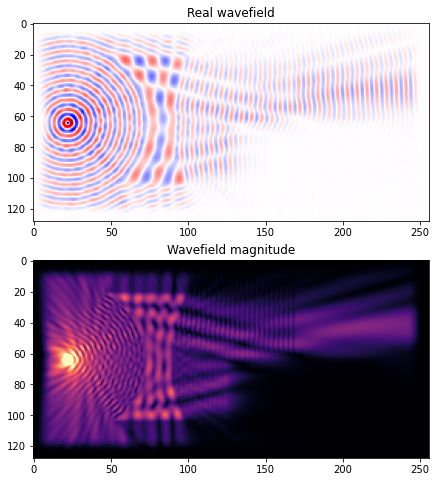

In [17]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

In [18]:
print("Runtime with GMRES")
%timeit solver(params).block_until_ready()

Runtime with GMRES
2.1 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
params, solver = setup_simulation(medium, "bicgstab")
field = solver(params)

print("Runtime with BiCGSTAB")
%timeit solver(params).block_until_ready()

Runtime with BiCGSTAB
349 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=None,
    pml_size=15
)

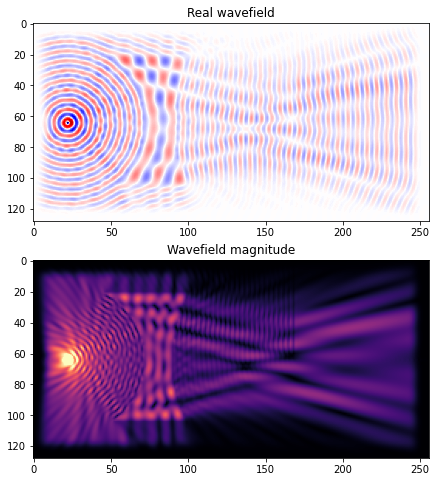

In [10]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

In [11]:
attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:110,125:220].set(0.1)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=attenuation,
    pml_size=15
)

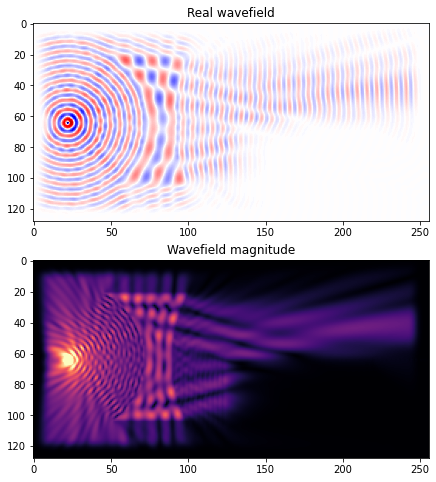

In [12]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

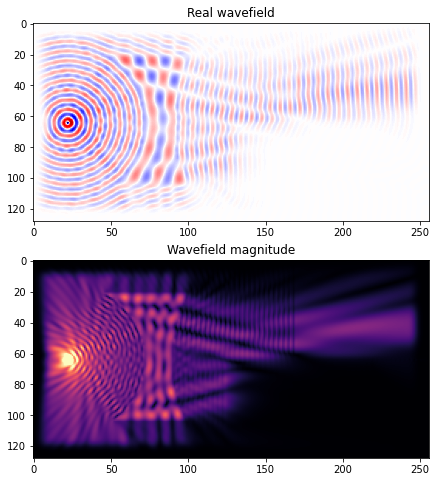

In [13]:
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15
)
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

In [14]:
params, solver = ongrid_helmholtz_solver(
    medium, 
    omega=omega,
    tol=1e-5, 
    restart=5,
    method="gmres",
    maxiter=1000,
    source = src_field
)

solver = jit(solver)
field = solver(params)

Text(0.5, 1.0, 'Wavefield magnitude')

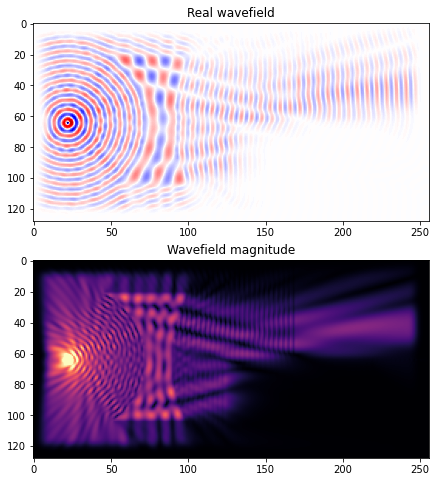

In [15]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
axes[1].set_title("Wavefield magnitude")